## 1. Prepare data and voxelMorph code



In [1]:
import neurite as ne

In [2]:
import voxelmorph2d as vm2d
import voxelmorph3d as vm3d

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
from skimage.filters import threshold_otsu
import multiprocessing as mp
from tqdm import tqdm
import gc
import time
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable

use_gpu = torch.cuda.is_available()

In [3]:
from skimage.color import rgb2gray

In [4]:
import os
import cv2

In [5]:
import importlib
importlib.reload(vm2d)

<module 'voxelmorph2d' from '/Users/nastya/Documents/ucu/thesis/voxelmorph/voxelmorph2d.py'>

In [6]:
from PIL import Image
import torch
from torchvision import datasets

## 2. Preparing GANs

In [ ]:
mnist = datasets.MNIST(root='/Users/nastya/Documents/ucu/thesis/diffeomorphic_demons/src/data', train=True, download=True, transform=None)

indices = mnist.targets == 5
mnist.data, mnist.targets = mnist.data[indices], mnist.targets[indices]

split_tensors = torch.split(mnist.data, mnist.data.size(0) // 2)

if len(mnist.data) % 2 != 0:
    tensor1, tensor2 = split_tensors[0], split_tensors[1]
else:
    tensor1, tensor2 = split_tensors

source_images, target_images = tensor1.numpy(), tensor2.numpy()

100%|██████████| 9912422/9912422 [00:00<00:00, 92788842.86it/s]


Extracting /Users/nastya/Documents/ucu/thesis/diffeomorphic_demons/src/data/MNIST/raw/train-images-idx3-ubyte.gz to /Users/nastya/Documents/ucu/thesis/diffeomorphic_demons/src/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7241492.94it/s]

Extracting /Users/nastya/Documents/ucu/thesis/diffeomorphic_demons/src/data/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/nastya/Documents/ucu/thesis/diffeomorphic_demons/src/data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32090218.72it/s]


Extracting /Users/nastya/Documents/ucu/thesis/diffeomorphic_demons/src/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/nastya/Documents/ucu/thesis/diffeomorphic_demons/src/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16565677.19it/s]

Extracting /Users/nastya/Documents/ucu/thesis/diffeomorphic_demons/src/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/nastya/Documents/ucu/thesis/diffeomorphic_demons/src/data/MNIST/raw



In [ ]:
pairs = list(zip(target_images, source_images))

In [ ]:
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

train_set, remaining_set = train_test_split(pairs, test_size=(validation_ratio + test_ratio), random_state=42)
validation_set, test_set = train_test_split(remaining_set, test_size=test_ratio / (validation_ratio + test_ratio), random_state=42)

In [ ]:
# import pickle

# with open('/content/train_mnist.pkl', "wb") as f:
#     pickle.dump(train_set, f)

# with open('/content/val_mnist.pkl', "wb") as f:
#     pickle.dump(validation_set, f)

# with open('/content/test_mnist.pkl', "wb") as f:
#     pickle.dump(test_set, f)

In [ ]:
# !zip -r /content/mnist_split.zip /content/mnist_split

  adding: content/mnist_split/ (stored 0%)
  adding: content/mnist_split/val_mnist.pkl (deflated 79%)
  adding: content/mnist_split/test_mnist.pkl (deflated 79%)
  adding: content/mnist_split/train_mnist.pkl (deflated 79%)


In [ ]:
train_set = train_set + validation_set

In [8]:
class MnistDataset(data.Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        target_image = self.pairs[idx][0]
        source_image = self.pairs[idx][1]

        source_image = cv2.resize(source_image, (32, 32))
        target_image = cv2.resize(target_image, (32, 32))

        source_image = (source_image > 127).view(np.uint8) * 255
        target_image = (target_image > 127).view(np.uint8) * 255

        target_image = torch.Tensor(target_image)
        source_image = torch.Tensor(source_image)

        return target_image, source_image

In [ ]:
train_data = MnistDataset(train_set)

In [ ]:
batch_size = 32

training_generator = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [9]:
class VoxelMorph():
    """
    VoxelMorph Class is a higher level interface for both 2D and 3D
    Voxelmorph classes. It makes training easier and is scalable.
    """

    def __init__(self, input_dims, is_2d=False, use_gpu=False):
        self.dims = input_dims
        if is_2d:
            self.vm = vm2d
            self.voxelmorph = vm2d.VoxelMorph2d(input_dims[0] * 2, use_gpu)
        else:
            self.vm = vm3d
            self.voxelmorph = vm3d.VoxelMorph3d(input_dims[0] * 2, use_gpu)
        self.optimizer = optim.SGD(self.voxelmorph.parameters(), lr=1e-4, momentum=0.99)
        self.params = {'batch_size': 3,
                       'shuffle': True,
                       'num_workers': 6,
                       'worker_init_fn': np.random.seed(42)
                       }
        self.device = torch.device("cuda:0" if use_gpu else "cpu")

    def check_dims(self, x):
        try:
            if x.shape[1:] == self.dims:
                return
            else:
                raise TypeError
        except TypeError as e:
            print("Invalid Dimension Error. The supposed dimension is ",
                  self.dims, "But the dimension of the input is ", x.shape[1:])

    def forward(self, x):
        self.check_dims(x)
        return voxelmorph(x)

    def calculate_loss(self, y, ytrue, n=9, lamda=0.01, is_training=True):
        loss = self.vm.vox_morph_loss(y, ytrue, n, lamda)
        return loss

    def train_model(self, batch_moving, batch_fixed, n=9, lamda=0.01, return_metric_score=True):
        self.optimizer.zero_grad()
        batch_fixed, batch_moving = batch_fixed.to(self.device), batch_moving.to(self.device)
        registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
        print(batch_fixed.shape)
        train_loss = self.calculate_loss(registered_image, batch_fixed, n, lamda)
        train_loss.backward()
        self.optimizer.step()
        if return_metric_score:
            train_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return train_loss, train_dice_score
        return train_loss

    def get_test_loss(self, batch_moving, batch_fixed, n=9, lamda=0.01):
        with torch.set_grad_enabled(False):
            registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
            val_loss = self.vm.vox_morph_loss(registered_image, batch_fixed, n, lamda)
            val_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return val_loss, val_dice_score

## 3. GANs

In [10]:
def add_conv_stage(dim_in, dim_out, kernel_size = 4, stride = 2, padding = 1, bias = False):
  return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.2, inplace=True)
  )

  ## Define discriminator
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            add_conv_stage(64, 128),
            add_conv_stage(128, 256),
            add_conv_stage(256, 512),
            nn.Conv2d(512, 1, 4,2,1, bias = False),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()
        )

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        return self.layers(input)


In [11]:
## Generator
vm = VoxelMorph((1, 28, 28), is_2d=True,  use_gpu=use_gpu)

generator = vm.voxelmorph


In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
D = discriminator()
G = generator

lr_g = 2e-4
lr_d = 1e-4

D_losses = []
G_losses = []
G_losses_total = []

BCELoss = nn.BCELoss()
MSELoss = nn.MSELoss()
KLDiveLoss = nn.KLDivLoss()

SmoothingLoss = vm2d.smooothing_loss

G_optimizer = optim.Adam(G.parameters(), lr=lr_g, betas=(.5, 0.999))
# D_optimizer = optim.Adam(D.parameters(), lr=lr_d, betas=(.5, 0.999))
D_optimizer = optim.SGD(D.parameters(), lr=lr_d)

if use_gpu:
    G = G.cuda()
    D = D.cuda()
D.apply(weights_init)
G.apply(weights_init)

VoxelMorph2d(
  (unet): UNet(
    (conv_encode1): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2,

In [ ]:
epochs = 80
train_interval = 5
for epoch in tqdm(range(epochs)):

    for batch_moving, batch_fixed in training_generator:

        mini_batch = batch_moving.shape[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        if use_gpu:
            y_real_ = y_real_.cuda()
            y_fake_ = y_fake_.cuda()
            batch_moving = batch_moving.cuda()
            batch_fixed = batch_fixed.cuda()

        batch_fixed = batch_fixed.unsqueeze(3)
        batch_moving = batch_moving.unsqueeze(3)

        batch_fixed_reorder = batch_fixed.permute(0, 3, 1, 2)
        batch_moving_reorder = batch_moving.permute(0, 3, 1, 2)

        # Train discriminator D
        D.zero_grad()
        # D_real = D(batch_moving_reorder).view(-1)

        D_real = torch.mean(D(batch_moving_reorder), dim=(1, 2, 3))

        D_real_loss = BCELoss(D_real, Variable(y_real_))
        D_real_loss.backward()

        with torch.no_grad():
            dat_fake, _ = G(batch_moving, batch_fixed)
        dat_fake_reorder = dat_fake.permute(0, 3, 1, 2)

        # D_fake = D(dat_fake_reorder).view(-1)
        D_fake = torch.mean(D(dat_fake_reorder), dim=(1, 2, 3))

        D_fake_loss = BCELoss(D_fake, Variable(y_fake_))
        D_fake_loss.backward()

        D_optimizer.step()
        D_train_loss = D_real_loss + D_fake_loss
        D_losses.append(D_train_loss.data.item())

        # Train generator G
        for iter in range(train_interval):

            G.zero_grad()
            dat_fake, _ = G(batch_moving, batch_fixed)
            dat_fake_reorder = dat_fake.permute(0, 3, 1, 2)

            with torch.no_grad():
            #   D_fake = D(dat_fake_reorder).view(-1)
                D_fake = torch.mean(D(dat_fake_reorder), dim=(1, 2, 3))
            G_train_loss = BCELoss(D_fake, Variable(y_real_))
            G_train_loss_total = G_train_loss + 1e-3*MSELoss(dat_fake, batch_fixed)+1e-3*SmoothingLoss(dat_fake)

            G_train_loss_total.backward()
            G_optimizer.step()
            G_losses.append(G_train_loss.data.item())
            G_losses_total.append(G_train_loss_total.data.item())

    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f, loss_g_total: %.3f' % ((epoch + 1), epochs,
                                                    torch.mean(torch.FloatTensor(D_losses)),
                                                    torch.mean(torch.FloatTensor(G_losses)),
                                                    torch.mean(torch.FloatTensor(G_losses_total))))


  1%|▏         | 1/80 [00:10<13:26, 10.21s/it]

[1/80] - loss_d: 1.412, loss_g: 0.591, loss_g_total: 7.439


  2%|▎         | 2/80 [00:19<12:52,  9.91s/it]

[2/80] - loss_d: 1.374, loss_g: 0.630, loss_g_total: 6.657


  4%|▍         | 3/80 [00:30<12:52, 10.04s/it]

[3/80] - loss_d: 1.351, loss_g: 0.644, loss_g_total: 6.231


  5%|▌         | 4/80 [00:39<12:24,  9.79s/it]

[4/80] - loss_d: 1.332, loss_g: 0.649, loss_g_total: 5.943


  6%|▋         | 5/80 [00:47<11:27,  9.17s/it]

[5/80] - loss_d: 1.314, loss_g: 0.652, loss_g_total: 5.729


  8%|▊         | 6/80 [00:57<11:46,  9.55s/it]

[6/80] - loss_d: 1.297, loss_g: 0.653, loss_g_total: 5.564


  9%|▉         | 7/80 [01:05<10:56,  8.99s/it]

[7/80] - loss_d: 1.281, loss_g: 0.655, loss_g_total: 5.431


 10%|█         | 8/80 [01:13<10:27,  8.71s/it]

[8/80] - loss_d: 1.266, loss_g: 0.656, loss_g_total: 5.324


 11%|█▏        | 9/80 [01:21<10:05,  8.53s/it]

[9/80] - loss_d: 1.252, loss_g: 0.658, loss_g_total: 5.236


 12%|█▎        | 10/80 [01:31<10:19,  8.85s/it]

[10/80] - loss_d: 1.238, loss_g: 0.660, loss_g_total: 5.160


 14%|█▍        | 11/80 [01:44<11:40, 10.16s/it]

[11/80] - loss_d: 1.225, loss_g: 0.661, loss_g_total: 5.095


 15%|█▌        | 12/80 [01:58<12:56, 11.41s/it]

[12/80] - loss_d: 1.212, loss_g: 0.663, loss_g_total: 5.039


 16%|█▋        | 13/80 [02:07<11:50, 10.61s/it]

[13/80] - loss_d: 1.200, loss_g: 0.665, loss_g_total: 4.990


 18%|█▊        | 14/80 [02:15<10:52,  9.89s/it]

[14/80] - loss_d: 1.189, loss_g: 0.666, loss_g_total: 4.946


 19%|█▉        | 15/80 [02:24<10:12,  9.43s/it]

[15/80] - loss_d: 1.178, loss_g: 0.668, loss_g_total: 4.907


 20%|██        | 16/80 [02:37<11:13, 10.53s/it]

[16/80] - loss_d: 1.167, loss_g: 0.670, loss_g_total: 4.872


 21%|██▏       | 17/80 [02:46<10:45, 10.25s/it]

[17/80] - loss_d: 1.157, loss_g: 0.672, loss_g_total: 4.840


 22%|██▎       | 18/80 [02:54<09:51,  9.55s/it]

[18/80] - loss_d: 1.148, loss_g: 0.674, loss_g_total: 4.812


 24%|██▍       | 19/80 [03:03<09:17,  9.14s/it]

[19/80] - loss_d: 1.138, loss_g: 0.676, loss_g_total: 4.786


 25%|██▌       | 20/80 [03:11<08:55,  8.93s/it]

[20/80] - loss_d: 1.130, loss_g: 0.678, loss_g_total: 4.762


 26%|██▋       | 21/80 [03:19<08:36,  8.75s/it]

[21/80] - loss_d: 1.121, loss_g: 0.680, loss_g_total: 4.740


 28%|██▊       | 22/80 [03:28<08:17,  8.58s/it]

[22/80] - loss_d: 1.113, loss_g: 0.683, loss_g_total: 4.720


 29%|██▉       | 23/80 [03:36<08:04,  8.50s/it]

[23/80] - loss_d: 1.104, loss_g: 0.685, loss_g_total: 4.701


 30%|███       | 24/80 [03:44<07:47,  8.35s/it]

[24/80] - loss_d: 1.096, loss_g: 0.687, loss_g_total: 4.684


 31%|███▏      | 25/80 [03:52<07:35,  8.29s/it]

[25/80] - loss_d: 1.089, loss_g: 0.689, loss_g_total: 4.667


 32%|███▎      | 26/80 [04:00<07:26,  8.26s/it]

[26/80] - loss_d: 1.081, loss_g: 0.691, loss_g_total: 4.652


 34%|███▍      | 27/80 [04:08<07:15,  8.21s/it]

[27/80] - loss_d: 1.074, loss_g: 0.693, loss_g_total: 4.638


 35%|███▌      | 28/80 [04:16<07:03,  8.15s/it]

[28/80] - loss_d: 1.067, loss_g: 0.695, loss_g_total: 4.626


 36%|███▋      | 29/80 [04:25<07:05,  8.34s/it]

[29/80] - loss_d: 1.060, loss_g: 0.697, loss_g_total: 4.613


 38%|███▊      | 30/80 [04:33<06:54,  8.30s/it]

[30/80] - loss_d: 1.054, loss_g: 0.700, loss_g_total: 4.602


 39%|███▉      | 31/80 [04:42<06:51,  8.39s/it]

[31/80] - loss_d: 1.047, loss_g: 0.702, loss_g_total: 4.591


 40%|████      | 32/80 [04:50<06:46,  8.46s/it]

[32/80] - loss_d: 1.041, loss_g: 0.704, loss_g_total: 4.581


 41%|████▏     | 33/80 [04:59<06:33,  8.37s/it]

[33/80] - loss_d: 1.035, loss_g: 0.706, loss_g_total: 4.572


 42%|████▎     | 34/80 [05:07<06:19,  8.26s/it]

[34/80] - loss_d: 1.028, loss_g: 0.708, loss_g_total: 4.562


 44%|████▍     | 35/80 [05:15<06:10,  8.22s/it]

[35/80] - loss_d: 1.022, loss_g: 0.711, loss_g_total: 4.554


 45%|████▌     | 36/80 [05:23<06:01,  8.22s/it]

[36/80] - loss_d: 1.017, loss_g: 0.713, loss_g_total: 4.545


 46%|████▋     | 37/80 [05:31<05:49,  8.14s/it]

[37/80] - loss_d: 1.011, loss_g: 0.715, loss_g_total: 4.538


 48%|████▊     | 38/80 [05:39<05:42,  8.15s/it]

[38/80] - loss_d: 1.005, loss_g: 0.717, loss_g_total: 4.530


 49%|████▉     | 39/80 [05:49<05:49,  8.53s/it]

[39/80] - loss_d: 1.000, loss_g: 0.719, loss_g_total: 4.523


 50%|█████     | 40/80 [05:57<05:37,  8.43s/it]

[40/80] - loss_d: 0.994, loss_g: 0.722, loss_g_total: 4.517


 51%|█████▏    | 41/80 [06:05<05:23,  8.29s/it]

[41/80] - loss_d: 0.989, loss_g: 0.724, loss_g_total: 4.511


 52%|█████▎    | 42/80 [06:13<05:13,  8.26s/it]

[42/80] - loss_d: 0.984, loss_g: 0.726, loss_g_total: 4.505


 54%|█████▍    | 43/80 [06:21<05:05,  8.25s/it]

[43/80] - loss_d: 0.979, loss_g: 0.728, loss_g_total: 4.499


 55%|█████▌    | 44/80 [06:29<04:53,  8.16s/it]

[44/80] - loss_d: 0.974, loss_g: 0.731, loss_g_total: 4.494


 56%|█████▋    | 45/80 [06:37<04:46,  8.18s/it]

[45/80] - loss_d: 0.969, loss_g: 0.733, loss_g_total: 4.489


 57%|█████▊    | 46/80 [06:46<04:38,  8.19s/it]

[46/80] - loss_d: 0.964, loss_g: 0.735, loss_g_total: 4.484


 59%|█████▉    | 47/80 [06:53<04:28,  8.12s/it]

[47/80] - loss_d: 0.959, loss_g: 0.738, loss_g_total: 4.479


 60%|██████    | 48/80 [07:02<04:24,  8.27s/it]

[48/80] - loss_d: 0.955, loss_g: 0.740, loss_g_total: 4.475


 61%|██████▏   | 49/80 [07:10<04:15,  8.24s/it]

[49/80] - loss_d: 0.950, loss_g: 0.742, loss_g_total: 4.470


 62%|██████▎   | 50/80 [07:18<04:04,  8.15s/it]

[50/80] - loss_d: 0.945, loss_g: 0.744, loss_g_total: 4.466


 64%|██████▍   | 51/80 [07:26<03:57,  8.18s/it]

[51/80] - loss_d: 0.941, loss_g: 0.747, loss_g_total: 4.463


 65%|██████▌   | 52/80 [07:35<03:49,  8.18s/it]

[52/80] - loss_d: 0.937, loss_g: 0.749, loss_g_total: 4.459


 66%|██████▋   | 53/80 [07:43<03:39,  8.12s/it]

[53/80] - loss_d: 0.932, loss_g: 0.751, loss_g_total: 4.455


 68%|██████▊   | 54/80 [07:51<03:31,  8.15s/it]

[54/80] - loss_d: 0.928, loss_g: 0.754, loss_g_total: 4.452


 69%|██████▉   | 55/80 [07:59<03:24,  8.18s/it]

[55/80] - loss_d: 0.924, loss_g: 0.756, loss_g_total: 4.449


 70%|███████   | 56/80 [08:07<03:15,  8.14s/it]

[56/80] - loss_d: 0.920, loss_g: 0.758, loss_g_total: 4.446


 71%|███████▏  | 57/80 [08:15<03:06,  8.12s/it]

[57/80] - loss_d: 0.916, loss_g: 0.761, loss_g_total: 4.443


 72%|███████▎  | 58/80 [08:23<02:59,  8.15s/it]

[58/80] - loss_d: 0.911, loss_g: 0.763, loss_g_total: 4.441


 74%|███████▍  | 59/80 [08:32<02:50,  8.14s/it]

[59/80] - loss_d: 0.907, loss_g: 0.765, loss_g_total: 4.438


 75%|███████▌  | 60/80 [08:40<02:43,  8.18s/it]

[60/80] - loss_d: 0.903, loss_g: 0.768, loss_g_total: 4.436


 76%|███████▋  | 61/80 [08:48<02:35,  8.19s/it]

[61/80] - loss_d: 0.900, loss_g: 0.770, loss_g_total: 4.434


 78%|███████▊  | 62/80 [08:56<02:27,  8.21s/it]

[62/80] - loss_d: 0.896, loss_g: 0.772, loss_g_total: 4.431


 79%|███████▉  | 63/80 [09:04<02:18,  8.13s/it]

[63/80] - loss_d: 0.892, loss_g: 0.775, loss_g_total: 4.429


 80%|████████  | 64/80 [09:12<02:10,  8.14s/it]

[64/80] - loss_d: 0.888, loss_g: 0.777, loss_g_total: 4.427


 81%|████████▏ | 65/80 [09:21<02:02,  8.15s/it]

[65/80] - loss_d: 0.884, loss_g: 0.780, loss_g_total: 4.426


 82%|████████▎ | 66/80 [09:29<01:53,  8.08s/it]

[66/80] - loss_d: 0.881, loss_g: 0.782, loss_g_total: 4.424


 84%|████████▍ | 67/80 [09:37<01:45,  8.13s/it]

[67/80] - loss_d: 0.877, loss_g: 0.785, loss_g_total: 4.422


 85%|████████▌ | 68/80 [09:45<01:37,  8.15s/it]

[68/80] - loss_d: 0.873, loss_g: 0.787, loss_g_total: 4.421


 86%|████████▋ | 69/80 [09:53<01:29,  8.10s/it]

[69/80] - loss_d: 0.870, loss_g: 0.790, loss_g_total: 4.419


 88%|████████▊ | 70/80 [10:01<01:21,  8.13s/it]

[70/80] - loss_d: 0.866, loss_g: 0.792, loss_g_total: 4.418


 89%|████████▉ | 71/80 [10:09<01:13,  8.17s/it]

[71/80] - loss_d: 0.863, loss_g: 0.794, loss_g_total: 4.417


 90%|█████████ | 72/80 [10:17<01:04,  8.12s/it]

[72/80] - loss_d: 0.859, loss_g: 0.797, loss_g_total: 4.416


 91%|█████████▏| 73/80 [10:26<00:56,  8.12s/it]

[73/80] - loss_d: 0.856, loss_g: 0.799, loss_g_total: 4.415


 92%|█████████▎| 74/80 [10:34<00:48,  8.15s/it]

[74/80] - loss_d: 0.852, loss_g: 0.802, loss_g_total: 4.414


 94%|█████████▍| 75/80 [10:42<00:40,  8.15s/it]

[75/80] - loss_d: 0.849, loss_g: 0.805, loss_g_total: 4.413


 95%|█████████▌| 76/80 [10:50<00:32,  8.20s/it]

[76/80] - loss_d: 0.845, loss_g: 0.807, loss_g_total: 4.412


 96%|█████████▋| 77/80 [10:58<00:24,  8.21s/it]

[77/80] - loss_d: 0.842, loss_g: 0.810, loss_g_total: 4.411


 98%|█████████▊| 78/80 [11:07<00:16,  8.20s/it]

[78/80] - loss_d: 0.839, loss_g: 0.812, loss_g_total: 4.411


 99%|█████████▉| 79/80 [11:15<00:08,  8.12s/it]

[79/80] - loss_d: 0.836, loss_g: 0.815, loss_g_total: 4.410


100%|██████████| 80/80 [11:23<00:00,  8.54s/it]

[80/80] - loss_d: 0.832, loss_g: 0.817, loss_g_total: 4.409


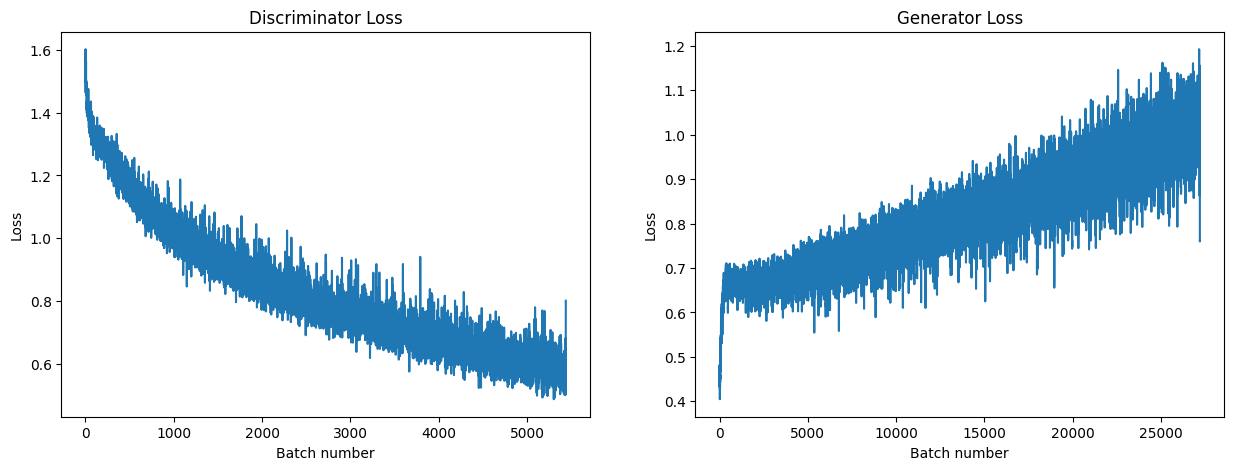

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(D_losses)
plt.title("Discriminator Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses)
plt.title("Generator Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss");

In [ ]:
D_losses_means = []
for i in range(0, len(D_losses), 32):
    chunk = D_losses[i:i+32]
    mean = sum(chunk) / len(chunk)
    D_losses_means.append(mean)

G_losses_means = []
for i in range(0, len(G_losses), 32):
    chunk = G_losses[i:i+32]
    mean = sum(chunk) / len(chunk)
    G_losses_means.append(mean)

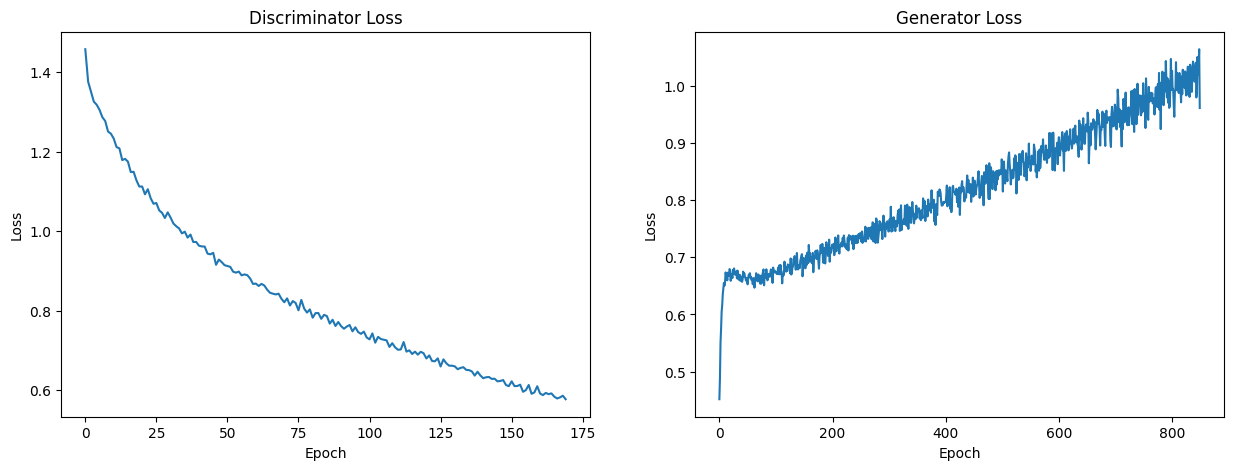

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(D_losses_means)
plt.title("Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses_means)
plt.title("Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss");

## Inference

In [ ]:
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')

In [ ]:
# def read_image(image_path):
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     image = cv2.resize(image, (256, 256))
#     image = torch.Tensor(image)

#     return image

In [ ]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.time()

fixed = []
moving = []

registered = []
deforms = []

test_data = MnistDataset(test_set)
test_generator = data.DataLoader(test_data, batch_size=1, shuffle=False)

for batch_fixed, batch_moving in test_generator:

    fixed.append(batch_fixed)
    moving.append(batch_moving)

    batch_fixed = batch_fixed.unsqueeze(3).to(device)
    batch_moving = batch_moving.unsqueeze(3).to(device)

    val_registered, defor = G(batch_moving, batch_fixed)

    registered.append(val_registered)
    deforms.append(defor)

end_time = time.time() - start_time

print(end_time)

3.6081087589263916


Text(0.5, 1.0, 'Moving Image')

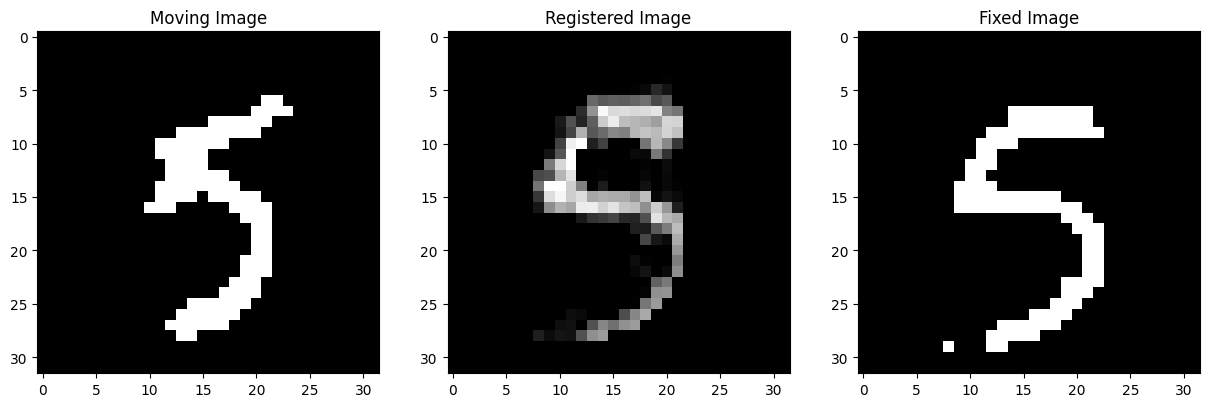

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[3].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[3].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[3].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

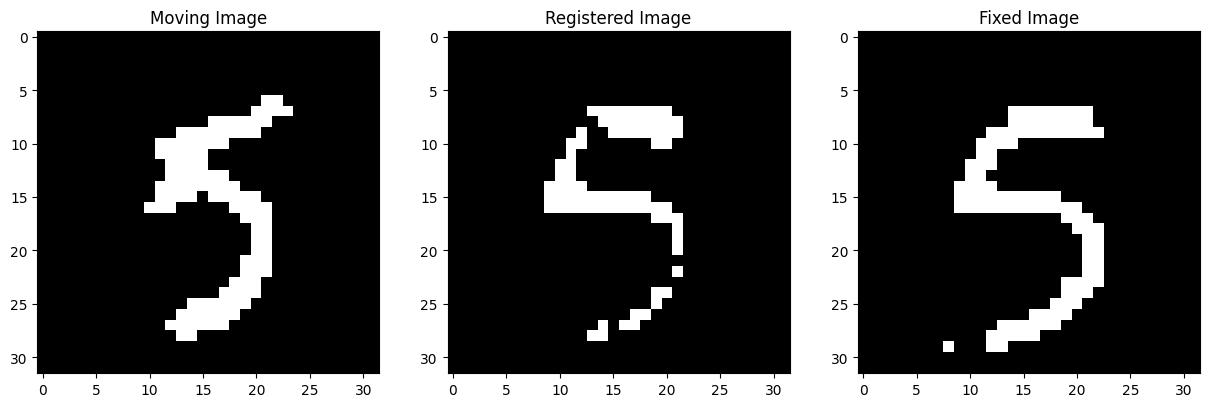

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow((registered[3].cpu().data.numpy().squeeze() > 127).view(np.uint8) * 255,cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[3].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[3].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

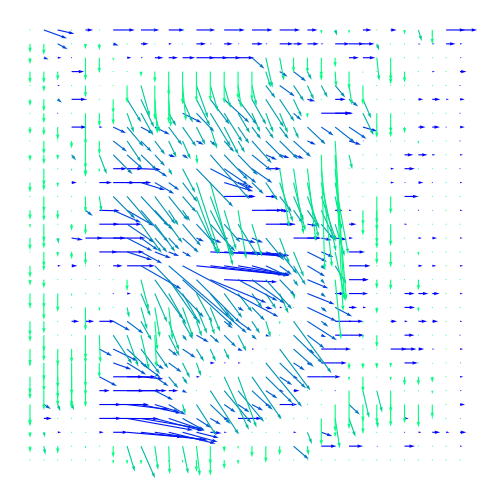

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [ ]:
ne.plot.flow([deforms[3].cpu().data.numpy().squeeze()], width = 5)

Text(0.5, 1.0, 'Moving Image')

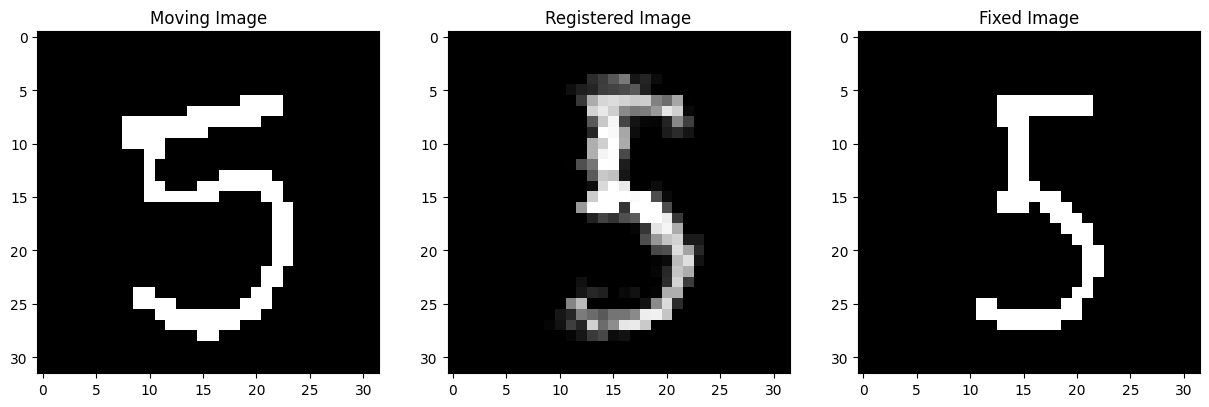

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[20].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[20].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[20].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

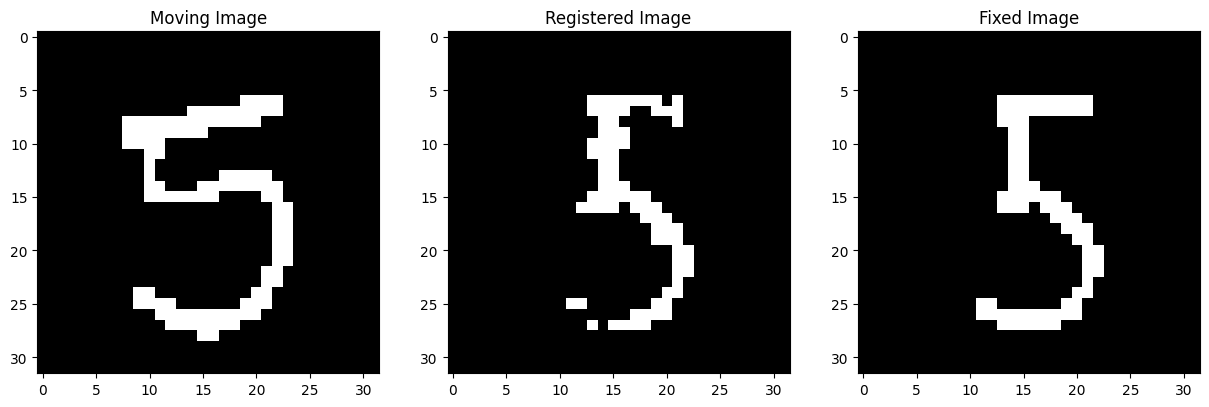

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow((registered[20].cpu().data.numpy().squeeze() > 127).view(np.uint8) * 255,cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[20].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[20].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

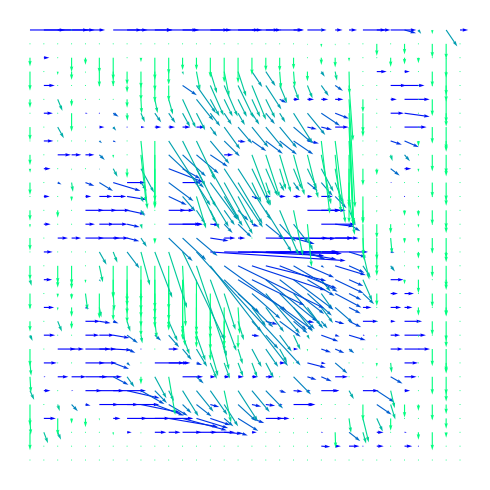

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [ ]:
ne.plot.flow([deforms[20].cpu().data.numpy().squeeze()], width = 5)

Text(0.5, 1.0, 'Moving Image')

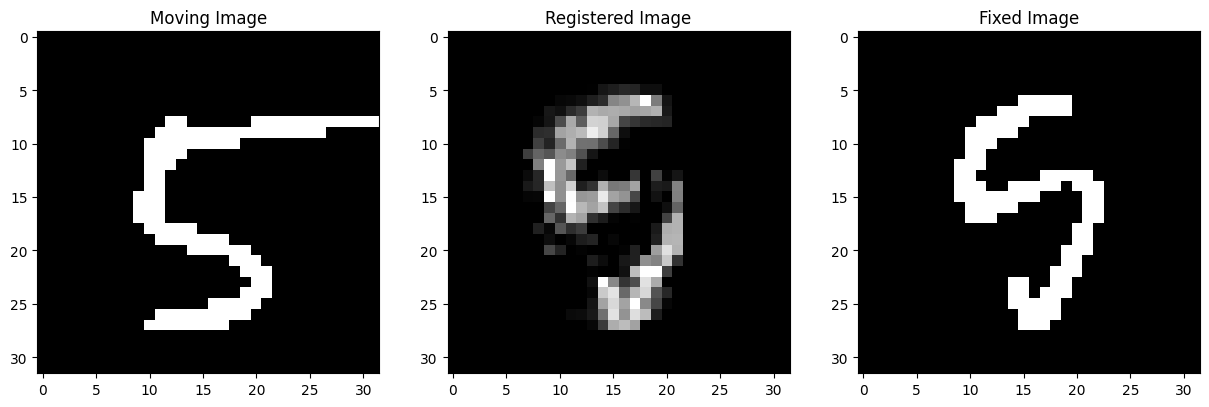

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[21].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[21].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[21].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

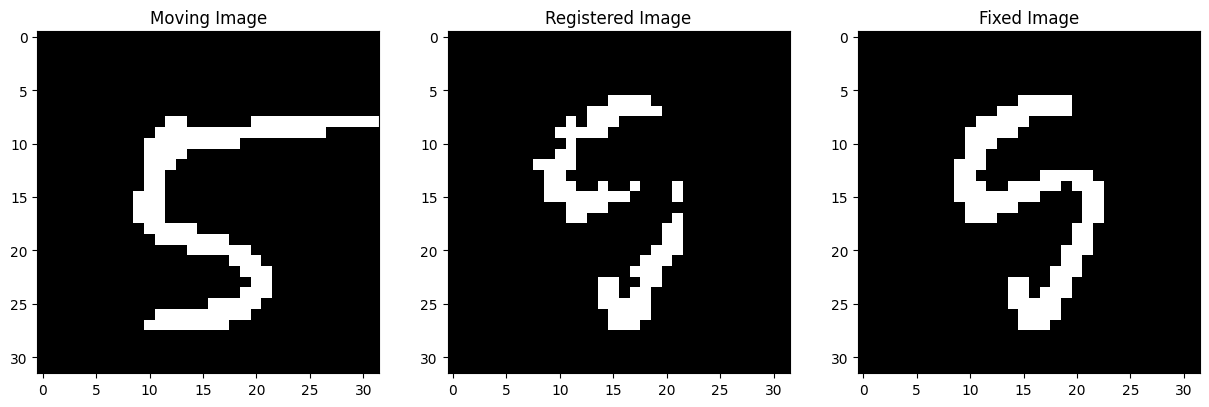

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow((registered[21].cpu().data.numpy().squeeze() > 127).view(np.uint8) * 255,cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[21].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[21].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

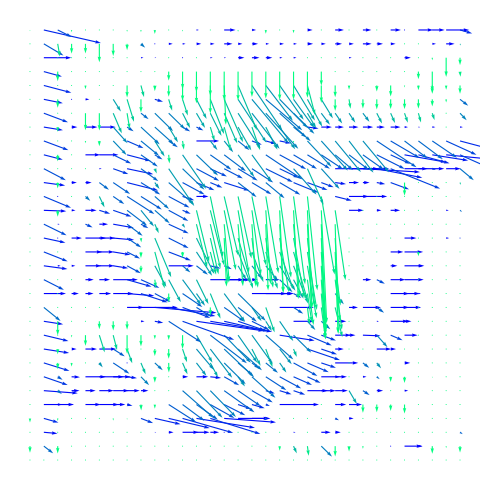

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [ ]:
ne.plot.flow([deforms[21].cpu().data.numpy().squeeze()], width = 5)

Text(0.5, 1.0, 'Moving Image')

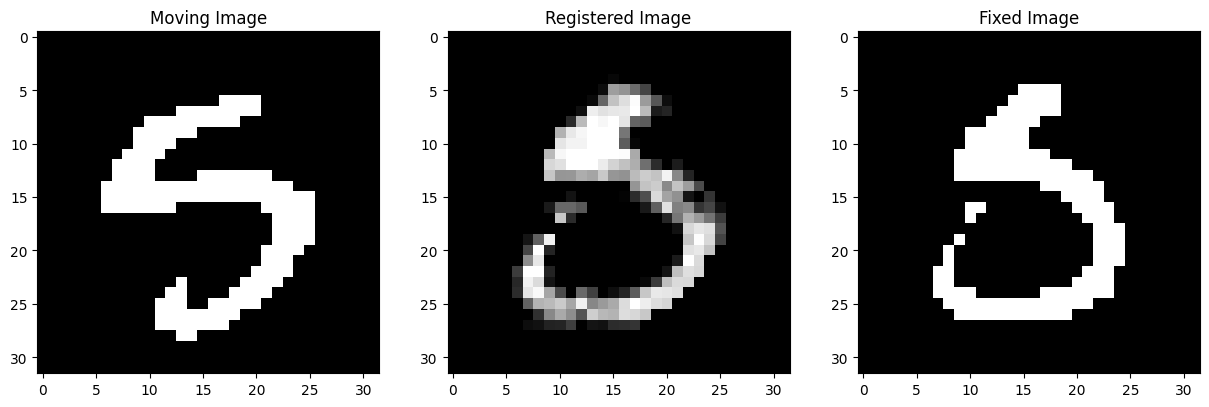

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[78].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[78].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[78].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

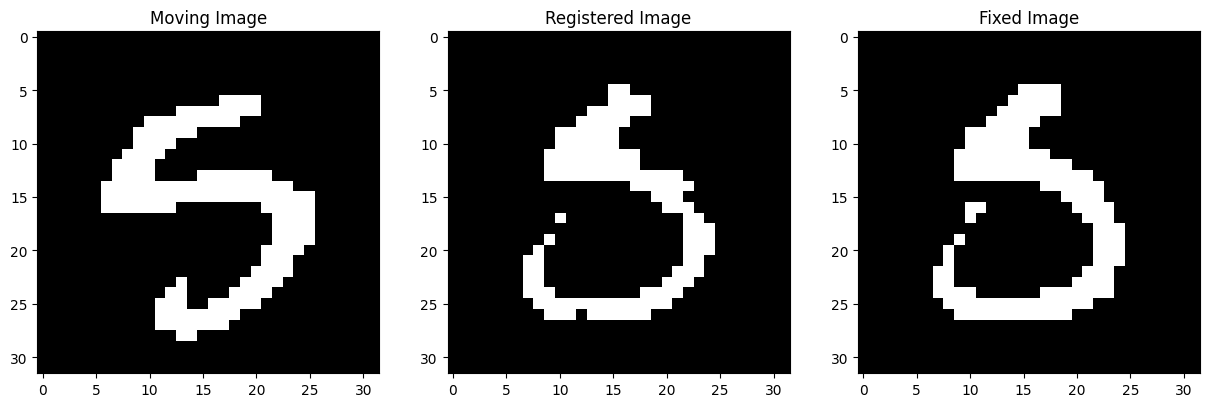

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow((registered[78].cpu().data.numpy().squeeze() > 127).view(np.uint8) * 255,cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[78].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[78].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

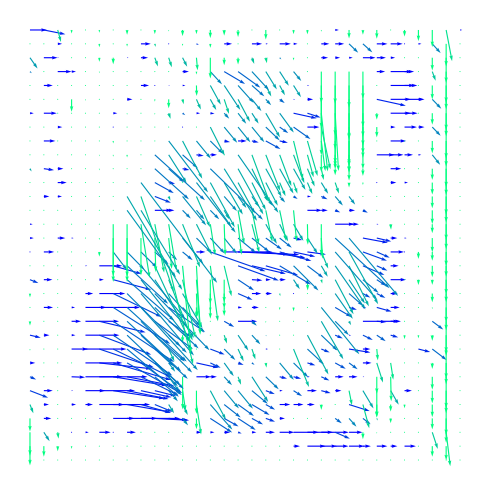

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [ ]:
ne.plot.flow([deforms[78].cpu().data.numpy().squeeze()], width = 5)

In [ ]:
def dice_score(image1, image2, threshold=True):
    # Convert images to grayscale
    if len(image1.shape) > 2:
        image1 = rgb2gray(image1)
    if len(image2.shape) > 2:
        image2 = rgb2gray(image2)

    # Thresholding (if required)
    if threshold:
        threshold_value1 = threshold_otsu(image1)
        threshold_value2 = threshold_otsu(image2)
        image1 = (image1 > threshold_value1).astype(np.uint8)
        image2 = (image2 > threshold_value2).astype(np.uint8)

    # Calculate Dice score
    intersection = np.sum(image1 & image2)
    union = np.sum(image1) + np.sum(image2)
    dice = (2.0 * intersection) / union
    return dice

In [ ]:
def mean_squared_error(image1, image2):
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    mse = np.mean((image1 - image2)**2)
    return mse

In [ ]:
dice_scores = []
mse_scores = []

for idx in range(len(fixed)):
    dice = dice_score(registered[idx].cpu().data.numpy().squeeze(), fixed[idx].cpu().data.numpy().squeeze())
    mse = mean_squared_error(registered[idx].cpu().data.numpy().squeeze(), fixed[idx].cpu().data.numpy().squeeze())

    dice_scores.append(dice)
    mse_scores.append(mse)

In [ ]:
import pandas as pd
metrics = pd.DataFrame(columns=['dice', 'mse'])

metrics['dice'] = dice_scores
metrics['mse'] = mse_scores

In [ ]:
metrics

,dice,mse
0,0.812785,2679.078857
1,0.872549,1719.057129
2,0.944984,1588.947754
3,0.805825,2262.849365
4,0.802920,2296.806885
...,...,...
537,0.713725,4810.632812
538,0.630952,3091.427734
539,0.798387,3115.395508
540,0.806084,2819.029297


In [ ]:
metrics.to_csv('metrics.csv', index=False)

In [ ]:
!zip -r /content/mnist_vm_gan_80epochs.zip /content/mnist_vm_gan_80epochs

  adding: content/mnist_vm_gan_80epochs/ (stored 0%)
  adding: content/mnist_vm_gan_80epochs/metrics.csv (deflated 56%)
  adding: content/mnist_vm_gan_80epochs/generator.pth (deflated 8%)
  adding: content/mnist_vm_gan_80epochs/discriminator.pth (deflated 7%)


In [ ]:
import os
from torchvision.utils import save_image
from PIL import Image

general_folder = 'voxelmorph_gan_mnist_inference'

if not os.path.exists(general_folder):
    os.makedirs(general_folder)

folder_names = ['fixed', 'moving', 'registered']

for folder_name, tensor_list in zip(folder_names, [validation_fixed, validation_moving, registered]):
    folder_path = os.path.join(general_folder, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for i, tensor in enumerate(tensor_list):
        image_path = os.path.join(folder_path, f'image_{i}.png')
        numpy_image = tensor.cpu().data.numpy().squeeze()

        numpy_image = numpy_image - np.min(numpy_image)
        numpy_image = numpy_image / np.max(numpy_image)
        pil_image = Image.fromarray((numpy_image * 255).astype(np.uint8))
        pil_image = pil_image.convert('RGB')
        pil_image.save(image_path)

In [ ]:
import pickle

output_file = 'defors_list.pkl'

with open(output_file, 'wb') as f:
    pickle.dump(defors, f)

In [ ]:
# !zip -r /content/voxelmorph_gan_mnist_inference.zip /content/voxelmorph_gan_mnist_inference

## INFERENCE FROM LOADED

In [14]:
import neurite as ne

In [15]:
G.load_state_dict(torch.load('/Users/nastya/Documents/ucu/thesis/voxelmorph/mnist/generator.pth', map_location=torch.device('cpu')))
D.load_state_dict(torch.load('/Users/nastya/Documents/ucu/thesis/voxelmorph/mnist/discriminator.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [16]:
import pickle

with open('/Users/nastya/Documents/ucu/thesis/data/mnist_split/test_mnist.pkl', "rb") as f:
    test_set = pickle.load(f)

In [17]:
test_data = MnistDataset(test_set)

In [18]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.time()

fixed = []
moving = []

registered = []
deforms = []

test_generator = data.DataLoader(test_data, batch_size=1, shuffle=False)

for batch_fixed, batch_moving in tqdm(test_generator):

    fixed.append(batch_fixed)
    moving.append(batch_moving)

    batch_fixed = batch_fixed.unsqueeze(3).to(device)
    batch_moving = batch_moving.unsqueeze(3).to(device)

    val_registered, defor = G(batch_moving, batch_fixed)

    registered.append(val_registered)
    deforms.append(defor)

end_time = time.time() - start_time

print(end_time)

100%|██████████| 542/542 [00:05<00:00, 97.62it/s] 

5.567249774932861


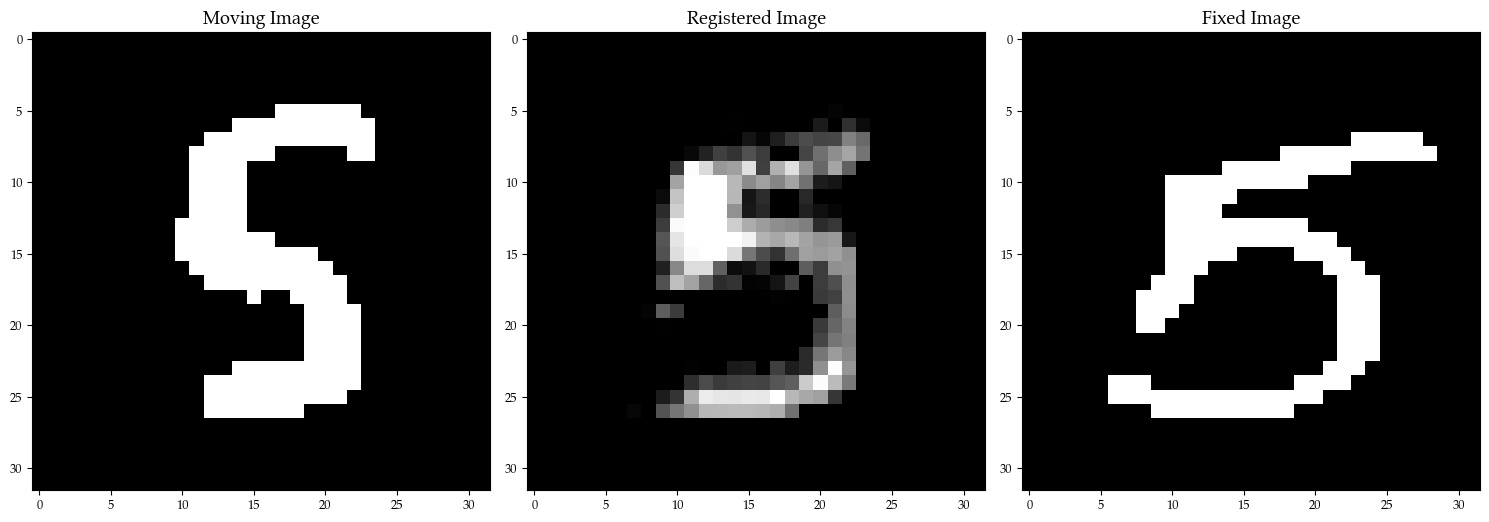

In [36]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[65].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(fixed[65].detach().numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(moving[65].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)

plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

### Metrics

In [19]:
def dice_score(image1, image2, threshold=True):
    # Convert images to grayscale
    if len(image1.shape) > 2:
        image1 = rgb2gray(image1)
    if len(image2.shape) > 2:
        image2 = rgb2gray(image2)

    # Thresholding (if required)
    if threshold:
        threshold_value1 = threshold_otsu(image1)
        threshold_value2 = threshold_otsu(image2)
        image1 = (image1 > threshold_value1).astype(np.uint8)
        image2 = (image2 > threshold_value2).astype(np.uint8)

    # Calculate Dice score
    intersection = np.sum(image1 & image2)
    union = np.sum(image1) + np.sum(image2)
    dice = (2.0 * intersection) / union
    return dice

In [20]:
def mean_squared_error(image1, image2):
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    mse = np.mean((image1 - image2)**2)
    return mse

In [21]:
dice_scores = []
mse_scores = []

for idx in range(len(registered)):

    registered_float = registered[idx].cpu().data.numpy().squeeze().astype(np.float64) / 255.0
    target_float = fixed[idx].cpu().data.numpy().squeeze().astype(np.float64) / 255.0

    dice = dice_score(registered_float, target_float)
    mse = mean_squared_error(registered_float, target_float)

    dice_scores.append(dice)
    mse_scores.append(mse)

In [22]:
import pandas as pd

metrics_data = pd.DataFrame({
    'dice': dice_scores,
    'mse': mse_scores
})

In [23]:
metrics_data

,dice,mse
0,0.800000,0.042012
1,0.824742,0.038222
2,0.894915,0.030798
3,0.852941,0.030267
4,0.706667,0.047494
...,...,...
537,0.720648,0.072909
538,0.720497,0.041025
539,0.772358,0.047574
540,0.787879,0.052933


In [24]:
metrics_data['dice'].mean()

0.7869170609570053

In [25]:
metrics_data['mse'].mean()

0.04518623676124749

In [26]:
metrics_data.to_csv('/Users/nastya/Documents/ucu/thesis/voxelmorph/mnist_vm_gan_80epochs/metrics_cpu.csv', index=False)

In [28]:
import pickle

with open('/Users/nastya/Documents/ucu/thesis/voxelmorph/mnist_vm_gan_80epochs/registered.pkl', 'wb') as f:
    pickle.dump(registered, f)